![Instituto Politécnico de Leiria](https://www.ipleiria.pt/wp-content/webpc-passthru.php?src=https://www.ipleiria.pt/wp-content/uploads/2021/10/estg_h-01.png&nocache=1)

<center>

# AI Driving Classification  <span style="font-size: 14px;">2023/2024</span>

<div align="center" style="font-weight: bold">Team Members:</div>

<div align="center">Alberto Manuel de Matos Pingo - 2202145</div>

<div align="center">João Pedro Quintela de Castro - 2201781</div>

---

## **First Approach - Stacked LSTM**

</center>

---

## Libraries

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

import keras
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import keras.backend as K


from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss, jaccard_score, coverage_error, label_ranking_loss

import folium

import seaborn as sns

from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from folium import plugins

import warnings
warnings.filterwarnings('ignore')

## Directories

In [2]:
import os

# Make auxiliar folders
if not os.path.exists('runtime_saves'):
    os.makedirs('runtime_saves')
if not os.path.exists('runtime_saves/models'):
    os.makedirs('runtime_saves/models')
if not os.path.exists('runtime_saves/data'):
    os.makedirs('runtime_saves/data')
if not os.path.exists('runtime_saves/visual'):
    os.makedirs('runtime_saves/visual')
    
dir_current = os.getcwd()
dir_root = os.path.abspath(os.path.join(dir_current, os.pardir, os.pardir))

dir_datasets = os.path.join(dir_root, 'datasets')

# Datasets
    # IPL-Dataset
dataset_Abrantes = os.path.join(dir_root, 'datasets', 'Abrantes-Leiria.csv')
dataset_DatasetAll = os.path.join(dir_root, 'datasets', 'Dataset-All.csv')
    # UAH
dataset_UAH_dir = os.path.join(dir_root, 'datasets', 'UAH-DRIVESET-v1', 'UAH-Processed')

print(f'Root directory: {dir_root}')
print(f'Datasets directory: {dir_datasets}')
print(f'Dataset directory: {dataset_Abrantes}')

Root directory: c:\codeUni\ProjetoInformatico\CoEProject-AI-DrivingClassification
Datasets directory: c:\codeUni\ProjetoInformatico\CoEProject-AI-DrivingClassification\datasets
Dataset directory: c:\codeUni\ProjetoInformatico\CoEProject-AI-DrivingClassification\datasets\Abrantes-Leiria.csv


# **AUX FUNCTIONS**

In [3]:
def save_manovers_positions_to_csv_file(gps_positions, manovers, filename):
  output = np.zeros_like(gps_positions)

  # Iterate through the elements of arr2
  for i in range(len(manovers)):
    # Check if the element in arr2 is 1
    if manovers[i] == 1:
      # Copy the corresponding values from arr1 to the output array
      output[i] = gps_positions[i]

  output = output[~np.all(output == 0, axis=1)]
  
  filename = 'runtime_saves/data/maneuver_' + filename
    
  np.savetxt(filename, output, delimiter=',', fmt='%.9f')

def separate_positives_negatives(data):
  # Ensure the input is converted to a NumPy array for easier manipulation
  data = np.array(data)

  # Create two empty arrays to store positive and negative values
  positives = np.zeros_like(data)
  negatives = np.zeros_like(data)

  # Use boolean indexing to separate positive and negative values
  positives[data > 0] = data[data > 0]
  negatives[data < 0] = -data[data < 0]

  # Combine the positive and negative values into a single 2D array
  return (positives, negatives)

def normalize_between_0_and_max(data):
  max_value = np.max(data)
  return data / max_value

def normalize_between_0_and_max_v2(data, max_value):
  return data / max_value

def split_train_test(data, test_size=0.2):
  # Check if test_size is between 0 and 1
  if test_size < 0 or test_size > 1:
    raise ValueError("test_size must be between 0 and 1.")

  # Get the number of samples
  num_samples = data.shape[0]

  # Calculate the number of samples for each set
  train_size = int(num_samples * (1 - test_size))
  test_size = num_samples - train_size

  # Randomly shuffle the data for better splitting (optional)
  #np.random.shuffle(data)

  # Split the data into training and X_test sets
  train_data = data[:train_size]
  test_data = data[train_size:]

  return train_data, test_data

def y_classification(data, threshold):
  classification = np.zeros_like(data, dtype=int)  # Initialize output array

  for col in range(0, 12):  # Loop through each column
    max_value = np.max(data[:, col])
    threshold_pos = max_value * threshold
    classification[:, col] = np.where(data[:, col] >= threshold_pos, 1, 0)

  return classification

def max_of_vectors(vec1, vec2, vec3, vec4, vec5, vec6):
  # Combine all vectors into a single array
  all_vectors = np.array([vec1, vec2, vec3, vec4, vec5, vec6])

  # Find the maximum value in the array
  max_value = np.max(all_vectors)

  return max_value

def has_one(data):
  """
  This function receives a numpy array and returns a new array
  with 1 if the correspondent row of input array has at least one cellule with 1.
  In other case the cellule is 0.

  Args:
      data: A numpy array of shape (n, 12) with 0 or 1 values in each cell.

  Returns:
      A numpy array of shape (n, 1) with 1s where the corresponding row in data has at least one 1, and 0s otherwise.
  """
  # We sum each row, and any value greater than zero indicates at least one 1 in that row
  return np.sum(data, axis=1)[:, np.newaxis] > 0

# **DATA PREPROCESSING**

## Data Structure

Accelerometer (m/s²): Acceleration along the each axis.
- **accelerometerXAxis**
- **accelerometerZAxis**
- **accelerometerYAxis**

Gyroscope (°/s): Angular velocity along the each axis.
- **gyroscopeXAxis**
- **gyroscopeYAxis**
- **gyroscopeZAxis**

GPS Coordinates (°): 
- **Latitude**
- **Longitude**

In [4]:
# Load the dataset into a DataFrame
df = pd.read_csv(dataset_Abrantes)
#df = pd.read_csv(dataset_DatasetAll)

acelX = df['accelerometerXAxis']
acelY = df['accelerometerYAxis']
acelZ = df['accelerometerZAxis']

gyrX = df['gyroscopeXAxis']
gyrY = df['gyroscopeYAxis']
gyrZ = df['gyroscopeZAxis']

latitude = df['latitude']
longitude = df['longitude']

## **Separate data by maneuver**

We identify different manovers based on the **Acceleration and Gyroscope data**.

Accelerometer:
- X - Curves
- Y - Acceleration and braking
- Z - Vertical acceleration - Uphill and downhill

Gyroscope:
- X - Longitudinal tilt - Uphill and downhill
- Y - Lateral tilt
- Z - Curves

In [5]:
maneuvers = [
    'Left Turn (Acc X+)', 'Right Turn (Acc X-)', 
    'Acceleration (Acc Y+)', 'Braking (Acc Y-)', 
    'Ascent (Acc Z+)', 'Descent (Acc Z-)', 
    'Left Lateral Tilt (Gyro X+)', 'Right Lateral Tilt (Gyro X-)',
    'Forward Tilt (Gyro Y+)', 'Backward Tilt (Gyro Y-)', 
    'Left Turn (Gyro Z+)', 'Right Turn (Gyro Z-)'
]

maneuvers_short = [
    'LT (Acc X+)', 'RT (Acc X-)', 
    'Acc (Acc Y+)', 'Brk (Acc Y-)', 
    'Asc (Acc Z+)', 'Des (Acc Z-)', 
    'Lat L (Gyro X+)', 'Lat R (Gyro X-)',
    'Tilt F (Gyro Y+)', 'Tilt B (Gyro Y-)', 
    'LT (Gyro Z+)', 'RT (Gyro Z-)'
]

In [6]:
# Curves (based on Acceleration along X-axis)
turnRightX, turnLeftX = separate_positives_negatives(acelX)  
# Acceleration and braking
accelY, breakY = separate_positives_negatives(acelY)
# Vertical acceleration - ascent and descent
positiveZ, negativeZ = separate_positives_negatives(acelZ)

# Lateral tilts - right and left
gyrPositiveX, gyrNegativeX = separate_positives_negatives(gyrX)

# Forward and backward tilts
gyrPositiveY, gyrNegativeY = separate_positives_negatives(gyrY)

# Curves (based on Gyro along Z-axis)
gyrPositiveZ, gyrNegativeZ = separate_positives_negatives(gyrZ)

turnRightX.shape

(35129,)

## Normalize Data

This process **helps the model performance** by rescaling specified columns of the dataset to a range between 0 and a max value. 

We identify the max value of the **original 3 axis** of the accelerometer and the **3 axis** of the gyroscope.

In [7]:
max_accel = max_of_vectors(turnRightX, turnLeftX, accelY, breakY, positiveZ, negativeZ)
max_gyr = max_of_vectors(gyrPositiveX, gyrNegativeX, gyrPositiveY, gyrNegativeY, gyrPositiveZ, gyrNegativeZ)

turnRightXn = normalize_between_0_and_max_v2(turnRightX, max_accel)
turnLeftXn = normalize_between_0_and_max_v2(turnLeftX, max_accel)
accelYn = normalize_between_0_and_max_v2(accelY, max_accel)
breakYn = normalize_between_0_and_max_v2(breakY, max_accel)
positiveZn = normalize_between_0_and_max_v2(positiveZ, max_accel)
negativeZn = normalize_between_0_and_max_v2(negativeZ, max_accel)
gyrPositiveXn = normalize_between_0_and_max_v2(gyrPositiveX, max_gyr)
gyrNegativeXn = normalize_between_0_and_max_v2(gyrNegativeX, max_gyr)
gyrPositiveYn = normalize_between_0_and_max_v2(gyrPositiveY, max_gyr)
gyrNegativeYn = normalize_between_0_and_max_v2(gyrNegativeY, max_gyr)
gyrPositiveZn = normalize_between_0_and_max_v2(gyrPositiveZ, max_gyr)
gyrNegativeZn = normalize_between_0_and_max_v2(gyrNegativeZ, max_gyr)

## Concatenate Data

This process concatenates all columns into a single DataFrame after the previous preprocessing steps.

In [8]:
x = np.array(list(zip(turnRightXn, turnLeftXn, accelYn, breakYn, positiveZn, negativeZn, gyrPositiveXn, gyrNegativeXn, gyrPositiveYn, gyrNegativeYn, gyrPositiveZn, gyrNegativeZn)))

x.shape

(35129, 12)

## **Labelling Data**

The labelling is done considering:
- The **Max value** of each column
- An **Adjustable threshold** between 0 and 1.

The product of this maximum value and the threshold establishes a reference point that indicates the intensity of the maneuver.

- If the data value is greater than or equal to the reference point, it will be classified as 1 (aggressive).

- If the data value is less than the reference point, it will be classified as 0 (non-aggressive).

In [9]:
y = y_classification(x, 0.3)
print (np.sum(y, axis=0))

print(y)

np.savetxt('runtime_saves/data/Y.csv', y, delimiter=',', fmt='%.0i')

[ 945  836  714  157  259  115  421  687  719  712 1144  375]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Maneuvers Statistics

Total distance: 84.11 km
Total # of maneuvers: {'Acceleration': 20354, 'Braking': 14775, 'Left Turn': 16657, 'Right Turn': 18472}


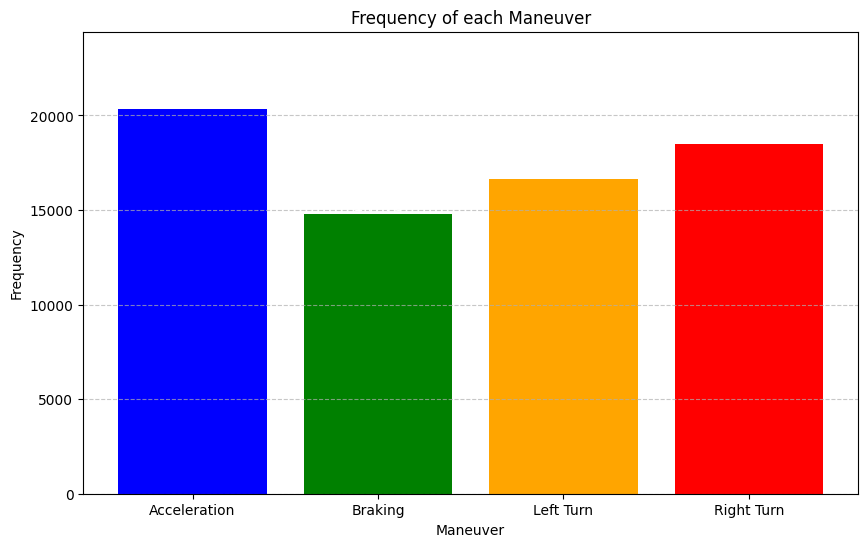

In [10]:
def count_maneuvers(accelY, breakY, turnLeftXn, turnRightXn):
    maneuvers = {
        'Acceleration': np.count_nonzero(accelY),
        'Braking': np.count_nonzero(breakY),
        'Left Turn': np.count_nonzero(turnLeftXn),
        'Right Turn': np.count_nonzero(turnRightXn)
    }
    
    return maneuvers

#calcula a disntancia entre dois pontos
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # +- raio da terra em metros
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c

def total_distance(lat, lon):
    distance = 0.0
    for i in range(1, len(lat)):
        distance += haversine(lat[i], lon[i], lat[i - 1], lon[i - 1])
    return distance

print(f'Total distance: {total_distance(latitude, longitude) / 1000:.2f} km')

print(f'Total # of maneuvers: {count_maneuvers(accelY, breakY, turnLeftXn, turnRightXn)}')

maneuvers_count = count_maneuvers(accelY, breakY, turnLeftXn, turnRightXn)

maneuvers_labels = list(maneuvers_count.keys())
maneuvers_quantidades = list(maneuvers_count.values())

colors = ['blue', 'green', 'orange', 'red']

plt.figure(figsize=(10, 6))
bars = plt.bar(maneuvers_labels, maneuvers_quantidades, color=colors)

for bar, quantity in zip(bars, maneuvers_quantidades):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.1, quantity,
             ha='center', va='bottom', color='white', fontsize=12)

plt.xlabel('Maneuver')
plt.ylabel('Frequency')
plt.title('Frequency of each Maneuver')
plt.ylim(0, max(maneuvers_quantidades) * 1.2)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Export maneuvers
Can be used on Google Maps to visualize the maneuvers.

In [11]:
positions = np.array(list(zip(latitude, longitude)))
maneuvers_accelY = y[:, 2]
maneuvers_breakY = y[:, 3]
maneuvers_turnRightXn = y[:, 0]
maneuvers_turnLeftXn = y[:, 1]
gyrPositiveZn = y[:, 10]
gyrNegativeZn = y[:, 11]
save_manovers_positions_to_csv_file(positions, maneuvers_accelY, "accelY.csv")
save_manovers_positions_to_csv_file(positions, maneuvers_breakY, "breakY.csv")
save_manovers_positions_to_csv_file(positions, maneuvers_turnRightXn, "turnRightX.csv")
save_manovers_positions_to_csv_file(positions, maneuvers_turnLeftXn, "turnLeftX.csv")
save_manovers_positions_to_csv_file(positions, gyrPositiveZn, "gyrPositZ.csv")
save_manovers_positions_to_csv_file(positions, gyrNegativeZn, "gyrNegZ.csv")

## Folium Map maneuvers

In [12]:
map = folium.Map(location=[np.mean(latitude), np.mean(longitude)], zoom_start=10)


marker_cluster = MarkerCluster().add_to(map)

for i in range(len(positions)):
    if maneuvers_accelY[i] == 1:
        folium.Marker([positions[i][0], positions[i][1]], icon=folium.Icon(color='blue'),popup=f'Acceleration').add_to(marker_cluster)
    if maneuvers_breakY[i] == 1:
        folium.Marker([positions[i][0], positions[i][1]], icon=folium.Icon(color='red'),popup=f'Braking').add_to(marker_cluster)
    if maneuvers_turnRightXn[i] == 1:
        folium.Marker([positions[i][0], positions[i][1]], icon=folium.Icon(color='green'),popup=f'Left Turn (Acc X+)').add_to(marker_cluster)
    if maneuvers_turnLeftXn[i] == 1:
        folium.Marker([positions[i][0], positions[i][1]], icon=folium.Icon(color='orange'),popup=f'Right Turn (Acc X-)').add_to(marker_cluster)
   
    if gyrNegativeZn[i] == 1:
        folium.Marker([positions[i][0], positions[i][1]], icon=folium.Icon(color='black'),popup=f'Left Turn (Gyro Z-)').add_to(marker_cluster)
    if gyrPositiveZn[i] == 1:
        folium.Marker([positions[i][0], positions[i][1]], icon=folium.Icon(color='purple'),popup=f'Rigth Turn (Gyro Z+)').add_to(marker_cluster)


map.save('runtime_saves/maneuvers.html')
map

# Split Dataset for Model Training

This section splits the dataset into training, test, and validation sets

- 75% Training
- 25% Test

In [13]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

#shape
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))    

(26346, 12) (26346, 12)
(8783, 12) (8783, 12)
{0: 310859, 1: 5293}


## Create input tensor data

In [14]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Save 
np.save('runtime_saves/data/X_train.npy', X_train)
np.save('runtime_saves/data/X_test.npy', X_test)
np.savetxt('runtime_saves/data/y_train.csv', y_train)
np.savetxt('runtime_saves/data/y_test.csv', y_test)

np.savetxt('runtime_saves/data/X_train.csv', X_train.reshape(X_train.shape[0], X_train.shape[2]), delimiter=',', fmt='%.9f')
np.savetxt('runtime_saves/data/X_test.csv', X_test.reshape(X_test.shape[0], X_test.shape[2]), delimiter=',', fmt='%.9f')

(26346, 1, 12) (26346, 12)
(8783, 1, 12) (8783, 12)


# **MODEL ARCHITECTURE** - Stacked LSTM

**Architecture:**

Input -> LSTM -> Dropout -> LSTM -> Dropout -> Dense -> Dense - Output

1. **Input Layer**
   - The input layer expects sequences with shape `(timesteps, features)`, where `timesteps` is the number of time steps and `features` is the number of features at each time step.

2. **LSTM Layers**
   - The model contains two LSTM layers, each with 64 units.
   - `return_sequences=True` is used for the first LSTM layer to ensure that the output at each time step is returned, which is necessary for stacking multiple LSTM layers.

3. **Fully Connected (Dense) Layers**
   - A dense layer with 32 units and ReLU activation, followed by a dense layer with 12 units and sigmoid activation for the output.

**Overfitting Measures**
   - Dropout layers are utilized after each LSTM layer to reduce the risk of overfitting by preventing the model from relying too heavily on any single feature or connection.

In [15]:
model = Sequential()

model.add(LSTM(64, input_shape=(1, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64))
model.add(Dropout(0.2))

model.add(Dense(32,activation='relu'))

model.add(Dense(12,activation='sigmoid'))

## Compile Model

**Loss function:** \
Use the *Binary Crossentropy* loss function because it is a `binary multi-class classification` problem.

**Optimizer:** \
Exploring the *Adam* optimizer.

**Metrics:** \
The *accuracy* metric is used to evaluate the model.

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             19712     
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 12)                396       
                                                                 
Total params: 55212 (215.67 KB)
Trainable params: 55212 

## Train Model

- 30 epochs
- Batch size of 64
- Early stopping
- Learning rate reduction on plateau
- Model checkpoint

In [18]:
# Define callbacks

best_model_file = 'runtime_saves/models/checkpoints/1A-StackedLSTM_CP.keras'
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=0.0000)
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=30,  batch_size=64, callbacks=[early_stopping,best_model,reduce_lr], validation_data=(X_test, y_test))

Epoch 1/30


402/412 [============================>.] - ETA: 0s - loss: 0.1723 - accuracy: 0.0234
Epoch 1: val_loss improved from inf to 0.07901, saving model to runtime_saves/models/checkpoints\1A-StackedLSTM_CP.keras
412/412 [==============================] - 8s 7ms/step - loss: 0.1701 - accuracy: 0.0242 - val_loss: 0.0790 - val_accuracy: 0.0155 - lr: 0.0010
Epoch 2/30
407/412 [============================>.] - ETA: 0s - loss: 0.0672 - accuracy: 0.0670
Epoch 2: val_loss improved from 0.07901 to 0.06314, saving model to runtime_saves/models/checkpoints\1A-StackedLSTM_CP.keras
412/412 [==============================] - 2s 5ms/step - loss: 0.0670 - accuracy: 0.0665 - val_loss: 0.0631 - val_accuracy: 0.0156 - lr: 0.0010
Epoch 3/30
409/412 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.0312
Epoch 3: val_loss improved from 0.06314 to 0.06174, saving model to runtime_saves/models/checkpoints\1A-StackedLSTM_CP.keras
412/412 [==============================] - 2s 5ms/s

## Save Model

In [19]:
model.save('runtime_saves/models/1A-StackedLSTM.keras')

## Load Model

In [15]:
from keras.models import load_model

model = load_model('runtime_saves/models/1A-StackedLSTM.keras')

# X_test = np.load('runtime_saves/data/X_test.npy')
# y_test = np.loadtxt('runtime_saves/data/y_test.csv', delimiter=',')

# **RESULTS AND EVALUATION**

## Training history

In [16]:
#plot loss e val_loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()

NameError: name 'history' is not defined

<Figure size 1000x600 with 0 Axes>























## Performance Metrics

- Accuracy  $\large = \frac{Correct~Predictions}{All~Predictions}$
- Precision for a given class  $\large = \frac{Correct~Predictions~for~the~Class}{All~Predictions~for~the~Class}$   
- Recall for a given class  $\large = \frac{Correct~Predictions~for~the~Class}{All~Instances~of~the~Class}$  
- F1 Score $\large = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$  
- Hamming Loss $\large = \frac{1}{N} \sum_{i=1}^{N} \frac{\text{Incorrect Labels}}{\text{Total Labels}}$  
- Jaccard Score $\large = \frac{|Y_{pred} \cap Y_{true}|}{|Y_{pred} \cup Y_{true}|}$  



- Averaging is a way to get a single number for multiclass. Depending on the importance one wants to give to minority classes: 
    - Macro average: Compute the metric for each class, and returns the average without considering the proportion for each class in the dataset. For instance:

        Precision = $\large = \frac{P_{class 1} ~+~ P_{class 2} ~+~ ... ~+~ P_{class n}}{N}$   
    
    - Weighted average: Compute the metric for each class, and returns the average considering the proportion (weighted) for each class in the dataset. For instance:

        Precision = $\large = \frac{N_1 ~*~ P_{class 1} ~+~ N_2 ~*~ P_{class 2} ~+~ ... ~+~ N_n ~*~ P_{class n}}{N}$

In [17]:
y_pred = model.predict(X_test)

y_pred = np.round(y_pred)

metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Hamming Loss', 'Jaccard Score'],
    'Value': [
        accuracy_score(y_test, y_pred) * 100,
        precision_score(y_test, y_pred, average="weighted") * 100,
        recall_score(y_test, y_pred, average="weighted") * 100,
        f1_score(y_test, y_pred, average="weighted") * 100,
        hamming_loss(y_test, y_pred) * 100,
        jaccard_score(y_test, y_pred, average="weighted") * 100,
    ]
}

metrics_df = pd.DataFrame(metrics)

# Percentage formatting
metrics_df['Value'] = metrics_df['Value'].map('{:.2f}%'.format)

metrics_df

275/275 [==============================] - 4s 4ms/step


Metric   Value
0       Accuracy  96.22%
1      Precision  91.81%
2         Recall  88.05%
3       F1 Score  89.18%
4   Hamming Loss   0.34%
5  Jaccard Score  81.56%

## Per-class Classification Report

In [18]:
from sklearn.metrics import classification_report

# Print classification report for each class
class_report = classification_report(y_test, y_pred, target_names=maneuvers)
print(class_report)

                              precision    recall  f1-score   support

          Left Turn (Acc X+)       0.96      0.91      0.94       246
         Right Turn (Acc X-)       0.90      0.97      0.94       229
       Acceleration (Acc Y+)       0.87      0.98      0.92       190
            Braking (Acc Y-)       0.72      0.41      0.52        32
             Ascent (Acc Z+)       0.98      0.62      0.76        79
            Descent (Acc Z-)       1.00      0.45      0.62        29
 Left Lateral Tilt (Gyro X+)       0.87      0.88      0.87        99
Right Lateral Tilt (Gyro X-)       0.91      0.91      0.91       170
      Forward Tilt (Gyro Y+)       0.95      0.88      0.92       184
     Backward Tilt (Gyro Y-)       0.94      0.96      0.95       167
         Left Turn (Gyro Z+)       0.93      0.94      0.94       270
        Right Turn (Gyro Z-)       0.88      0.52      0.65        96

                   micro avg       0.92      0.88      0.90      1791
                  

## Confusion Matrix

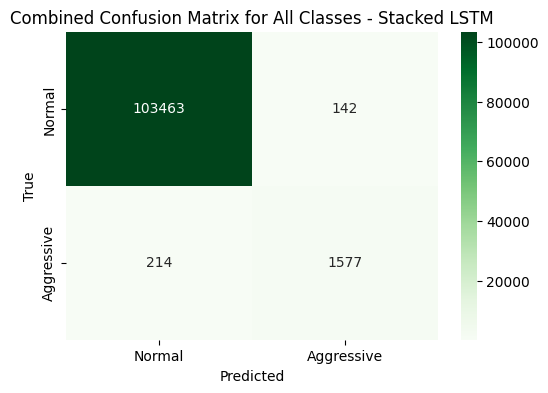

In [19]:
from sklearn.metrics import multilabel_confusion_matrix
# Binarize predictions at threshold 0.5
y_pred_classes = (y_pred > 0.5).astype(int)

# Multilabel confusion matrix
conf_matrices = multilabel_confusion_matrix(y_test, y_pred_classes)

# Aggregate confusion matrix
aggregated_conf_matrix = np.sum(conf_matrices, axis=0)

labels = ['Normal', 'Aggressive']

plt.figure(figsize=(6, 4))
sns.heatmap(aggregated_conf_matrix, annot=True, fmt="d", cmap="Greens", 
            xticklabels=labels, yticklabels=labels)
plt.title('Combined Confusion Matrix for All Classes - Stacked LSTM')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

## Per-Class Confusion Matrix

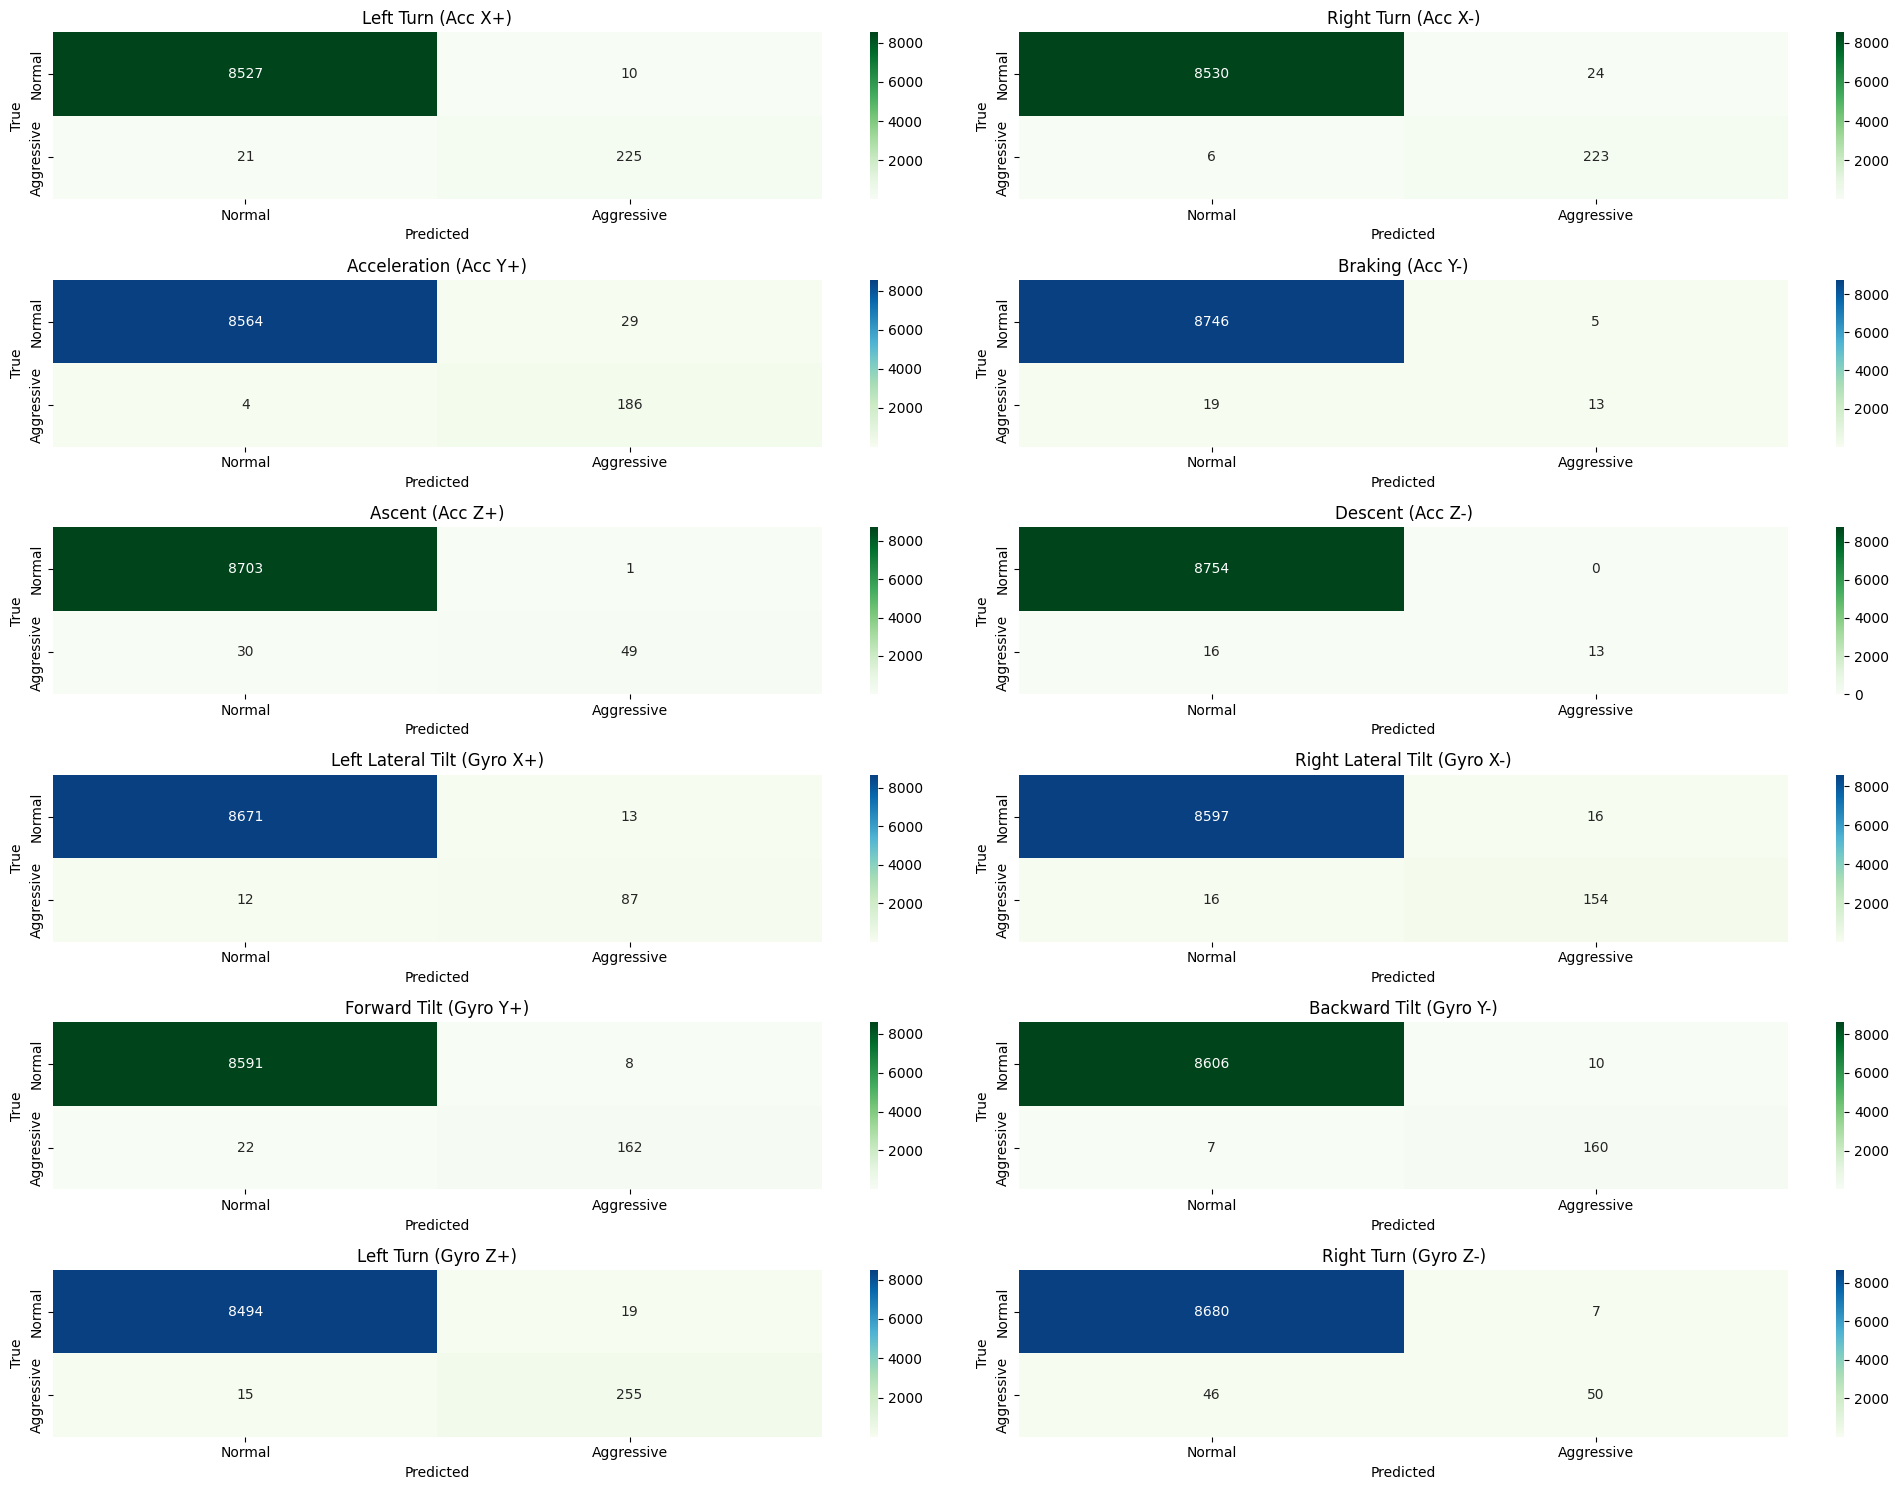

In [20]:
# Plotting each confusion matrix for the 12 classes

green_color_maps = ['Greens', 'GnBu']

plt.figure(figsize=(20, 15))
for i, matrix in enumerate(conf_matrices):
    color_map = green_color_maps[(i // 2) % len(green_color_maps)]
    
    plt.subplot(6, 2, i + 1)
    sns.heatmap(matrix, annot=True, fmt="d", cmap=color_map, 
                xticklabels=labels, yticklabels=labels)    
    plt.title(maneuvers[i])
    plt.ylabel('True')
    plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

## ROC Curve

The ROC curve visualizes a model's performance by plotting the True Positive Rate against the False Positive Rate at various thresholds. The Area Under the Curve (AUC) measures the model's ability to distinguish between classes, with a higher AUC indicating better performance.

Left Turn (Acc X+)             ROC AUC = 0.96
Right Turn (Acc X-)            ROC AUC = 0.99
Acceleration (Acc Y+)          ROC AUC = 0.99
Braking (Acc Y-)               ROC AUC = 0.70
Ascent (Acc Z+)                ROC AUC = 0.81
Descent (Acc Z-)               ROC AUC = 0.72
Left Lateral Tilt (Gyro X+)    ROC AUC = 0.94
Right Lateral Tilt (Gyro X-)   ROC AUC = 0.95
Forward Tilt (Gyro Y+)         ROC AUC = 0.94
Backward Tilt (Gyro Y-)        ROC AUC = 0.98
Left Turn (Gyro Z+)            ROC AUC = 0.97
Right Turn (Gyro Z-)           ROC AUC = 0.76


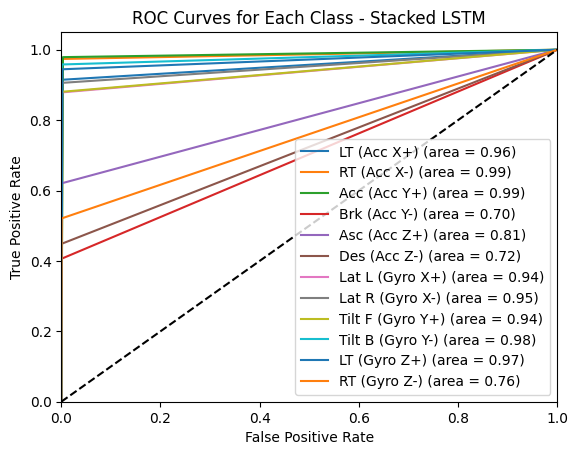

In [21]:
from sklearn.metrics import roc_curve, auc

# Generate ROC Curve for each class
for i in range(12):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{maneuvers_short[i]} (area = {roc_auc:.2f})')
    
    # Print ROC AUC value
    print(f'{maneuvers[i]:<30} ROC AUC = {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class - Stacked LSTM')
plt.legend(loc='lower right')
plt.show()

## Precision-Recall curves

Precision-Recall curves illustrate a model’s performance by plotting Precision against Recall for each class. These curves help evaluate how well the model balances precision and recall across different thresholds, especially in imbalanced datasets. Higher curves indicate better performance in identifying positive cases.

Left Turn (Acc X+)             Max Precision: 1.00 at Recall: 0.00	 Precision at Recall ~0.5: 0.96
Right Turn (Acc X-)            Max Precision: 1.00 at Recall: 0.00	 Precision at Recall ~0.5: 0.90
Acceleration (Acc Y+)          Max Precision: 1.00 at Recall: 0.00	 Precision at Recall ~0.5: 0.87
Braking (Acc Y-)               Max Precision: 1.00 at Recall: 0.00	 Precision at Recall ~0.5: 0.72
Ascent (Acc Z+)                Max Precision: 1.00 at Recall: 0.00	 Precision at Recall ~0.5: 0.98
Descent (Acc Z-)               Max Precision: 1.00 at Recall: 0.45	 Precision at Recall ~0.5: 1.00
Left Lateral Tilt (Gyro X+)    Max Precision: 1.00 at Recall: 0.00	 Precision at Recall ~0.5: 0.87
Right Lateral Tilt (Gyro X-)   Max Precision: 1.00 at Recall: 0.00	 Precision at Recall ~0.5: 0.91
Forward Tilt (Gyro Y+)         Max Precision: 1.00 at Recall: 0.00	 Precision at Recall ~0.5: 0.95
Backward Tilt (Gyro Y-)        Max Precision: 1.00 at Recall: 0.00	 Precision at Recall ~0.5: 0.94
Left Turn 

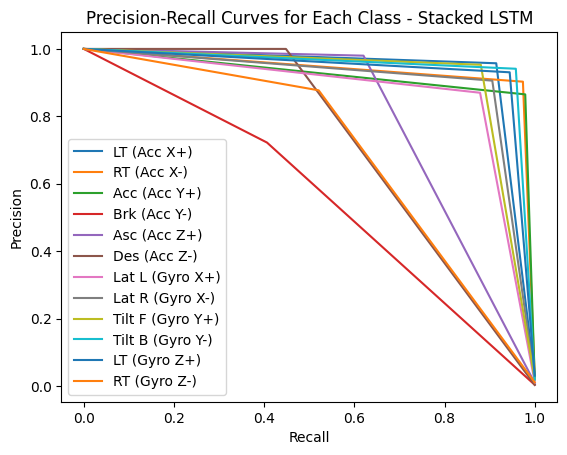

In [22]:
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

plt.figure()

# Generate Precision-Recall Curve for each class
for i in range(12):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    
    # Calculate maximum precision and recall
    max_precision_idx = precision.argmax()
    max_precision = precision[max_precision_idx]
    max_recall = recall[max_precision_idx]
    
    # Calculate precision at recall ~0.5
    threshold_idx = (np.abs(recall - 0.5)).argmin()
    precision_at = precision[threshold_idx] if threshold_idx < len(recall) else 'N/A'
    
    # Print summary for the class
    print(f'{maneuvers[i]:<30} Max Precision: {max_precision:.2f} at Recall: {max_recall:.2f}\t Precision at Recall ~0.5: {precision_at:.2f}')
    
    # Plot Precision-Recall Curve
    plt.plot(recall, precision, label=maneuvers_short[i])

# Plot settings
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Class - Stacked LSTM')
plt.legend(loc='lower left')
plt.show()

## Predict Test Data

4/4 [==============================] - 0s 3ms/step


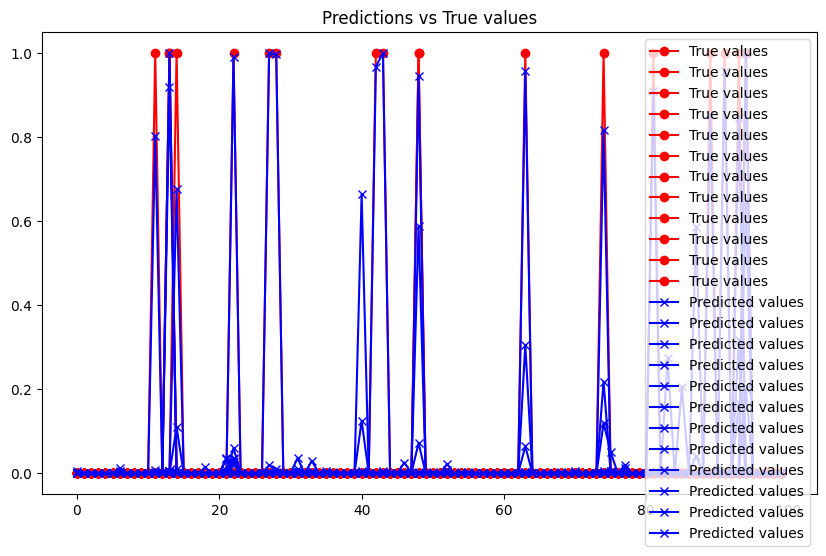

In [23]:
def test_model(model, test_data, test_labels, start, end):
    predictions = model.predict(test_data[start:end])

    plt.figure(figsize=(10, 6))
    plt.plot(test_labels[start:end], 'ro-', label='True values')
    plt.plot(predictions, 'bx-', label='Predicted values')
    plt.title('Predictions vs True values')
    plt.legend()
    plt.show()
    
    return predictions

predictions = test_model(model, X_test, y_test, 0, 100)

1/1 [==============================] - 0s 39ms/step


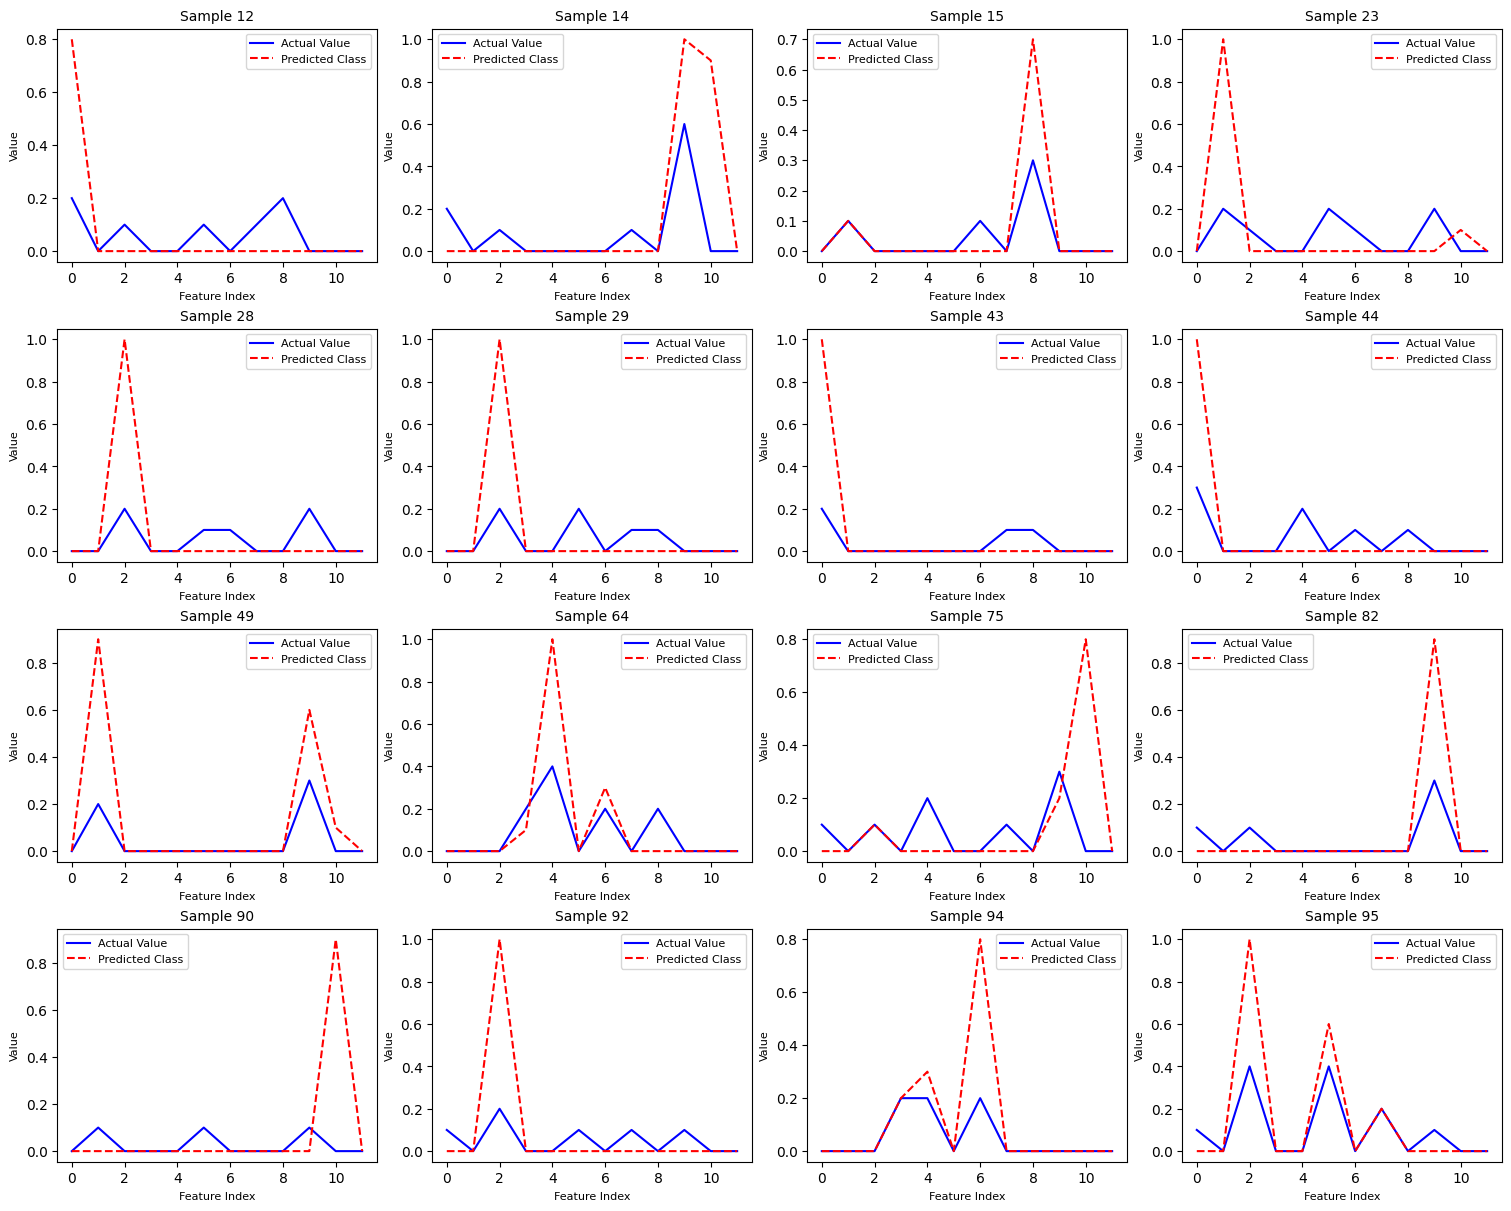

In [24]:
def visualize_predictions(x_test, y_test, model, num_samples=100):
    # List to store indices of valid samples
    valid_indices = []
    
    for i in range(num_samples):
        if np.sum(y_test[i]) > 0:
            valid_indices.append(i)
    
    num_valid_samples = len(valid_indices)
    
    if num_valid_samples == 0:
        print("No valid samples to plot.")
        return

    # Define the grid size based on the number of valid samples
    num_rows = int(math.ceil(num_valid_samples / 4))  # 5 columns per row
    num_cols = min(num_valid_samples, 4)  # Maximum of 5 columns

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3), constrained_layout=True)
    
    # Flatten the axs array to make indexing easier, and remove unused subplots
    axs = axs.flatten()
    
    for i, index in enumerate(valid_indices):
        a = x_test[index]
        b = a.reshape(1, 1, 12)

        prediction = model.predict(b)
        predicted_class = np.round(prediction.flatten(), decimals=1)

        actual_values = np.round(a.flatten(), decimals=1)
        true_class = np.round(y_test[index].flatten(), decimals=1)

        # Plot only if there is an actual class
        ax = axs[i]

        ax.plot(range(12), actual_values, 'b', label='Actual Value')
        ax.plot(range(12), predicted_class, 'r--', label='Predicted Class')

        ax.set_xlabel('Feature Index', fontsize=8)
        ax.set_ylabel('Value', fontsize=8)
        ax.set_title(f'Sample {index+1}', fontsize=10)
        ax.legend(fontsize=8)
    
    # Hide any remaining subplots that were not used
    for j in range(num_valid_samples, len(axs)):
        axs[j].axis('off')

    plt.show()

visualize_predictions(X_test, y_test, model, num_samples=100)

1/1 [==============================] - 0s 37ms/step
Value    : [0.    0.363 0.313 0.    0.    0.31  0.393 0.    0.    0.244 0.247 0.   ]
Predicted: [0.21 0.7  0.4  0.08 0.11 0.13 0.24 0.19 0.21 0.23 0.65 0.09]


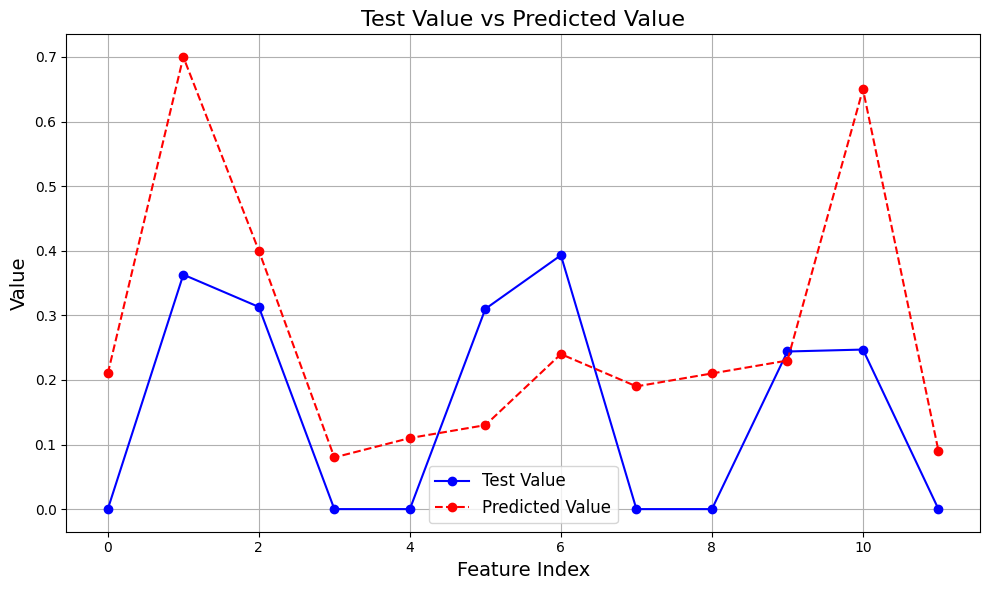

In [25]:
import numpy as np
import matplotlib.pyplot as plt


test_value = np.array([0., 0.363, 0.313, 0., 0., 0.31, 0.393, 0., 0., 0.244, 0.247, 0.])
test_value = test_value.reshape(1, 1, 12)

prediction = model.predict(test_value)
prediction = prediction.flatten()  
np.round(prediction, decimals=2, out=prediction)

print("Value    :", test_value[0][0])
print("Predicted:", prediction)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(range(12), test_value[0][0], 'bo-', label='Test Value')

ax.plot(range(12), prediction, 'ro--', label='Predicted Value')

ax.set_xlabel('Feature Index', fontsize=14)
ax.set_ylabel('Value', fontsize=14)
ax.set_title('Test Value vs Predicted Value', fontsize=16)
ax.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()